### Import libraries and set global options

In [1]:
from importlib import import_module
import logging
from os import path
import sys
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

SCRIPT_DIR = path.dirname(path.abspath('__file__'))
sys.path.append(path.dirname(SCRIPT_DIR))
sys.dont_write_bytecode = True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from darts.timeseries import TimeSeries

from library.datasets import get_dataframe_summarized, standarize, StandarizeMethod
from library.depresjon import get_measured_days, read_activity_dataset, read_scores_dataset
from library.model_persistence import load_model
from library.timeseries import extract_ts_features, ComputeFeatures

from sklearn.metrics import pairwise_distances, confusion_matrix, classification_report

from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import softmax

from typing import Any, Union


%matplotlib inline

In [3]:
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

seed = 90

random.seed(seed)
np.random.seed(seed)

### Define some helpers

In [4]:
def get_epsilon():
    return sys.float_info.epsilon

def transform_dataset(
    dataset_id: str,
    df: pd.DataFrame,
    frequency: str = '1T',
    summarize_method: str = 'sum',
    standarize_method: int = StandarizeMethod.DEFAULT,
    remove_outliers: bool = False
) -> pd.DataFrame:
    df_grouped = get_dataframe_summarized(df, frequency, summarize_method)
    df_grouped = df_grouped.rename(columns={'index': 'timestamp'})
    df_grouped['id'] = dataset_id
    df_grouped['activity'] = standarize(
        df_grouped.activity.to_numpy(),
        method = standarize_method,
        remove_outliers = remove_outliers
    )
    return df_grouped

def load_features(features_file_path:str) -> str:
    f = open(features_file_path, 'r')
    features_names = [line.strip() for line in f.readlines()]
    f.close()
    return features_names

def predict_proba(model, features):
    if isinstance(model, NearestCentroid):
        distances = pairwise_distances(features, model.centroids_, metric=model.metric)
        return softmax(distances)

    return model.predict_proba(features)

def get_args_for_model(model_class: str):
    if model_class == 'NaiveSeasonal':
        return { 'K': 168 }
    
    if model_class == 'XGBModel':
        return { 'lags': 24, 'random_state': seed }
    
    if model_class == 'ExponentialSmoothing':
        return { 'random_state': seed }
    
    if model_class == 'Prophet':
        return { 'floor': 0 }
    
    if model_class == 'FFT':
        return { 'nr_freqs_to_keep': 24 }

    return {}

def load_forecasting_model(model_class: str, model_path: str) -> Any:
    module = sys.modules['darts.models'] if 'darts.models' in sys.modules else import_module('darts.models')
    args = get_args_for_model(model_class)
    instance = getattr(module, model_class)(**args)
    instance.load(model_path)
    return instance

def extract_features_forecast(
    current_data: pd.DataFrame,
    forecasted_data: pd.DataFrame,
    samples_from_current_data: int = 1,
    samples_from_forecasted_data: int = 1
):
    return extract_ts_features(
        df = pd.concat(
            [
                current_data.tail(samples_from_current_data),
                forecasted_data.head(samples_from_forecasted_data)
            ],
            ignore_index = False
        ).reset_index(),
        compute_features = ComputeFeatures.ALL,
        column_id = 'id',
        column_sort = 'timestamp',
        column_value = 'activity',
        disable_progressbar = True
    )

def predict_activity_and_extract_features(
    id: str,
    model: any,
    data: TimeSeries,
):
    df_forecast = model.predict(24 * 7).pd_dataframe()
    df_forecast['id'] = id
    
    # features 3 days forecast activity mean
    features_3days_forecast = extract_features_forecast(
        current_data = data,
        forecasted_data = df_forecast,
        samples_from_current_data = 24 * 11,
        samples_from_forecasted_data = 24 * 3
    )

    # features 5 days forecast activity mean
    features_5days_forecast = extract_features_forecast(
        current_data = data,
        forecasted_data = df_forecast,
        samples_from_current_data = 24 * 9,
        samples_from_forecasted_data = 24 * 5
    )

    # features 7 days forecast activity mean
    features_7days_forecast = extract_features_forecast(
        current_data = data,
        forecasted_data = df_forecast,
        samples_from_current_data = 24 * 7,
        samples_from_forecasted_data = 24 * 7
    )
    
    return features_3days_forecast, features_5days_forecast, features_7days_forecast

### Define global variables

In [5]:
DATASETS_PATH = path.realpath(path.join(SCRIPT_DIR, '..', '..', 'dataset'))

RESULTS_PATH = path.realpath(path.join(SCRIPT_DIR, '..', '..', 'results'))

CLASSIFICATION_MODELS_PATH = path.realpath(
    path.join(RESULTS_PATH, 'classification', 'models', 'final')
)

CLASSIFICATION_MODELS_FEATURES_PATH = path.realpath(
    path.join(SCRIPT_DIR, '..', '..', 'dataset', 'features')
)

FORECASTING_MODELS_PATH = path.realpath(
    path.join(RESULTS_PATH, 'forecasting', 'models')
)

### Load scores dataset

In [6]:
# scores dataset
df_scores = read_scores_dataset(f'{DATASETS_PATH}/original/scores.csv')
df_scores.head()

days  gender    age  afftype  melanch  inpatient    edu  \
number                                                                 
condition_1    11       2  35-39   2.0000   2.0000     2.0000   6-10   
condition_2    18       2  40-44   1.0000   2.0000     2.0000   6-10   
condition_3    13       1  45-49   2.0000   2.0000     2.0000   6-10   
condition_4    13       2  25-29   2.0000   2.0000     2.0000  11-15   
condition_5    13       2  50-54   2.0000   2.0000     2.0000  11-15   

             marriage   work  madrs1  madrs2  
number                                        
condition_1    1.0000 2.0000 19.0000 19.0000  
condition_2    2.0000 2.0000 24.0000 11.0000  
condition_3    2.0000 2.0000 24.0000 25.0000  
condition_4    1.0000 1.0000 20.0000 16.0000  
condition_5    2.0000 2.0000 26.0000 26.0000

### Load activity datasets

In [7]:
hourly_activity_datasets = {}
for file, row in df_scores.iterrows():
    folder = file.split('_')[0]
    days = get_measured_days(df_scores, file)
    df = read_activity_dataset(f'{DATASETS_PATH}/original/{folder}/{file}.csv', days)
    
    hourly_activity_datasets[file] = {
        'mean': transform_dataset(
            file,
            df,
            frequency = '1H',
            summarize_method = 'mean',
            standarize_method = StandarizeMethod.ROBUST,
            remove_outliers = False
        ),
        'median': transform_dataset(
            file,
            df,
            frequency = '1H',
            summarize_method = 'median',
            standarize_method = StandarizeMethod.DEFAULT,
            remove_outliers = True
        )
    }

In [8]:
hourly_activity_datasets['condition_1']['mean'].head()

timestamp  activity           id
0 2003-05-08 00:00:00   -0.6786  condition_1
1 2003-05-08 01:00:00   -0.7073  condition_1
2 2003-05-08 02:00:00   -0.6854  condition_1
3 2003-05-08 03:00:00   -0.7077  condition_1
4 2003-05-08 04:00:00   -0.6477  condition_1

In [9]:
hourly_activity_datasets['condition_1']['median'].head()

timestamp  activity           id
0 2003-05-08 00:00:00   -0.6584  condition_1
1 2003-05-08 01:00:00   -0.6584  condition_1
2 2003-05-08 02:00:00   -0.6584  condition_1
3 2003-05-08 03:00:00   -0.6584  condition_1
4 2003-05-08 04:00:00   -0.6584  condition_1

#### Plot activity

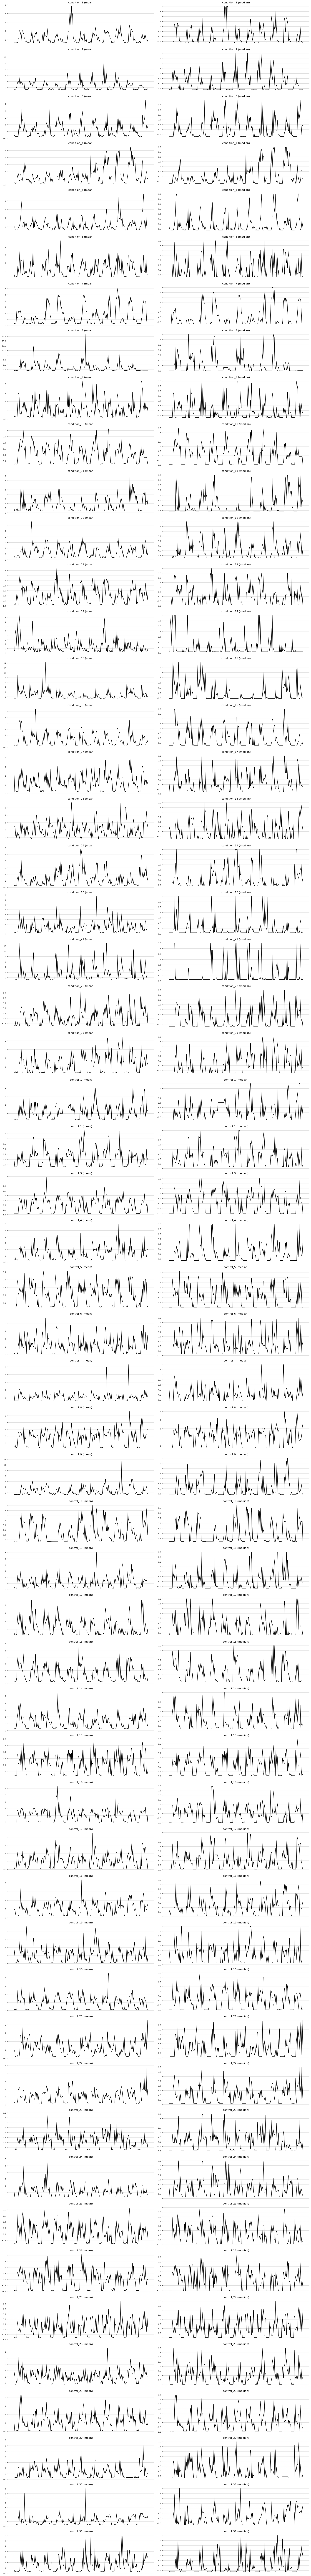

In [10]:
fig, axes = plt.subplots(
    nrows = len(hourly_activity_datasets),
    ncols = 2,
    figsize = (20, len(hourly_activity_datasets) * 3)
)

index = 0
for file, dfs in hourly_activity_datasets.items():
    dfs['mean'].activity.plot(ax = axes[index, 0], title=f'{file} (mean)', xticks=[])
    dfs['median'].activity.plot(ax = axes[index, 1], title=f'{file} (median)', xticks=[])
    index += 1
    
fig.tight_layout()
plt.show()

### Load models

#### Load classification models

In [11]:
classification_model_mean = load_model(
    path.abspath(
        f'{CLASSIFICATION_MODELS_PATH}/model__rlo__features_all_1H_mean_standarized_zscore-robust_outliers_no__20-features__loo.skops'
    )
)
classification_model_median = load_model(
    path.abspath(
        f'{CLASSIFICATION_MODELS_PATH}/model__rlo__features_all_1H_median_standarized_zscore_outliers_yes__10-features__loo.skops'
    )
)

In [12]:
classification_model_mean

LogisticRegressionCV(class_weight='balanced', cv=5, random_state=90,
                     solver='liblinear')

In [13]:
classification_model_median

LogisticRegressionCV(class_weight='balanced', cv=5, random_state=90,
                     solver='liblinear')

#### Load forecasting models

In [14]:
# load forecasting scores dataset (MAPE:min)
df_forecasting_scores = read_scores_dataset(path.realpath(path.join(RESULTS_PATH, 'forecasting', 'scores', 'scores_forecasting_models__MAPE_min.csv')))
df_forecasting_scores.head()

score_metric criteria best_model_mean  score_best_model_mean  \
number                                                                     
condition_1         MAPE      min   NaiveSeasonal               197.6005   
condition_2         MAPE      min   NaiveSeasonal               194.3737   
condition_3         MAPE      min         Prophet               135.7124   
condition_4         MAPE      min        XGBModel              1411.2185   
condition_5         MAPE      min         Prophet               341.0560   

                                               model_file_mean  \
number                                                           
condition_1  condition_1__hourly_mean__NaiveSeasonal__MAPE_...   
condition_2  condition_2__hourly_mean__NaiveSeasonal__MAPE_...   
condition_3    condition_3__hourly_mean__Prophet__MAPE_min.pkl   
condition_4   condition_4__hourly_mean__XGBModel__MAPE_min.pkl   
condition_5    condition_5__hourly_mean__Prophet__MAPE_min.pkl   

                best_model_median  score_best_model_median  \
number                                                       
condition_1         NaiveSeasonal                 106.2050   
condition_2              XGBModel                 375.4673   
condition_3  ExponentialSmoothing                 190.1347   
condition_4              XGBModel                 122.4244   
condition_5         NaiveSeasonal                 120.5166   

                                             model_file_median  
number                                                          
condition_1  condition_1__hourly_median__NaiveSeasonal__MAP...  
condition_2  condition_2__hourly_median__XGBModel__MAPE_min...  
condition_3  condition_3__hourly_median__ExponentialSmoothi...  
condition_4  condition_4__hourly_median__XGBModel__MAPE_min...  
condition_5  condition_5__hourly_median__NaiveSeasonal__MAP...

In [15]:
forecasting_models = {}
for id, row in df_forecasting_scores.iterrows():
    df_mean = hourly_activity_datasets[id]['mean'].set_index('timestamp')
    df_median = hourly_activity_datasets[id]['median'].set_index('timestamp')

    ts_hourly_mean = TimeSeries.from_series(df_mean.activity + get_epsilon())
    ts_hourly_median = TimeSeries.from_series(df_median.activity + get_epsilon())
    
    forecasting_models[id] = {
        'mean': load_forecasting_model(
            model_class = row['best_model_mean'],
            model_path = path.realpath(
                path.join(RESULTS_PATH, 'forecasting', 'models', row['model_file_mean'])
            )
        ).fit(ts_hourly_mean),
        'median': load_forecasting_model(
            model_class = row['best_model_median'],
            model_path = path.realpath(
                path.join(RESULTS_PATH, 'forecasting', 'models', row['model_file_median'])
            )
        ).fit(ts_hourly_median)
    }

### Load features for classification

In [16]:
features_names_mean = load_features(
    path.abspath(
        path.join(CLASSIFICATION_MODELS_FEATURES_PATH, 'all', '20-features', 'rlo', 'features_all_1H_mean_standarized_zscore-robust_outliers_no.txt')
    )
)

features_names_median = load_features(
    path.abspath(
        path.join(CLASSIFICATION_MODELS_FEATURES_PATH, 'all', '10-features', 'rlo', 'features_all_1H_median_standarized_zscore_outliers_yes.txt')
    )
)

In [17]:
features_names_mean

['activity__root_mean_square',
 'activity__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
 'activity__fft_coefficient__attr_"real"__coeff_0',
 'activity__fft_coefficient__attr_"real"__coeff_9',
 'activity__fft_coefficient__attr_"imag"__coeff_0',
 'activity__fft_coefficient__attr_"abs"__coeff_12',
 'activity__fft_coefficient__attr_"abs"__coeff_24',
 'activity__fft_coefficient__attr_"abs"__coeff_68',
 'activity__fft_coefficient__attr_"angle"__coeff_77',
 'activity__fft_coefficient__attr_"angle"__coeff_96',
 'activity__friedrich_coefficients__coeff_3__m_3__r_30']

In [18]:
features_names_median

['activity__count_below_mean',
 'activity__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)',
 'activity__fft_coefficient__attr_"real"__coeff_55',
 'activity__fft_coefficient__attr_"imag"__coeff_96',
 'activity__fft_coefficient__attr_"abs"__coeff_9',
 'activity__fft_coefficient__attr_"abs"__coeff_95',
 'activity__fft_coefficient__attr_"angle"__coeff_8']

### Generate features datasets for data

In [19]:
features_datasets = {
    'mean': pd.DataFrame(),
    'median': pd.DataFrame()
}
for file, dfs in hourly_activity_datasets.items():
    extracted_features_mean = extract_ts_features(
        dfs['mean'],
        ComputeFeatures.ALL,
        column_id = 'id',
        column_sort = 'timestamp',
        column_value = 'activity',
        disable_progressbar = True
    )
    
    extracted_features_median = extract_ts_features(
        dfs['median'],
        ComputeFeatures.ALL,
        column_id = 'id',
        column_sort = 'timestamp',
        column_value = 'activity',
        disable_progressbar = True
    )
            
    features_datasets['mean'] = pd.concat([
        features_datasets['mean'],
        extracted_features_mean,
    ])
    
    features_datasets['median'] = pd.concat([
        features_datasets['median'],
        extracted_features_median,
    ])
    
features_datasets['mean'] = features_datasets['mean'][features_names_mean]
features_datasets['median'] = features_datasets['median'][features_names_median]

In [20]:
features_datasets['mean'].head()

activity__root_mean_square  \
condition_1                      1.3843   
condition_2                      1.5586   
condition_3                      1.0047   
condition_4                      1.2681   
condition_5                      1.3672   

             activity__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4  \
condition_1                                             0.0797                      
condition_2                                             0.0597                      
condition_3                                             0.0681                      
condition_4                                             0.0250                      
condition_5                                             0.0238                      

             activity__fft_coefficient__attr_"real"__coeff_0  \
condition_1                                         110.2704   
condition_2                                         129.6049   
condition_3                                          55.7440   
condition_4                                          95.5921   
condition_5                                         102.3014   

             activity__fft_coefficient__attr_"real"__coeff_9  \
condition_1                                          15.6122   
condition_2                                           2.5641   
condition_3                                          -4.6675   
condition_4                                          44.4085   
condition_5                                          -3.9476   

             activity__fft_coefficient__attr_"imag"__coeff_0  \
condition_1                                           0.0000   
condition_2                                           0.0000   
condition_3                                           0.0000   
condition_4                                           0.0000   
condition_5                                           0.0000   

             activity__fft_coefficient__attr_"abs"__coeff_12  \
condition_1                                          27.0774   
condition_2                                          48.9311   
condition_3                                          24.5403   
condition_4                                          66.3135   
condition_5                                          24.9585   

             activity__fft_coefficient__attr_"abs"__coeff_24  \
condition_1                                          20.6188   
condition_2                                           8.5110   
condition_3                                           4.7581   
condition_4                                          28.0236   
condition_5                                           9.5306   

             activity__fft_coefficient__attr_"abs"__coeff_68  \
condition_1                                          17.5735   
condition_2                                          25.8267   
condition_3                                           5.6009   
condition_4                                           9.3174   
condition_5                                          27.6432   

             activity__fft_coefficient__attr_"angle"__coeff_77  \
condition_1                                           -51.7020   
condition_2                                            76.7484   
condition_3                                           109.2455   
condition_4                                            72.5258   
condition_5                                            89.5668   

             activity__fft_coefficient__attr_"angle"__coeff_96  \
condition_1                                            16.2698   
condition_2                                           -48.3741   
condition_3                                            -7.7569   
condition_4                                            59.4739   
condition_5                                           -97.0440   

             activity__friedrich_coefficients__coeff_3__m_3__r_30  
condition_1                                             0.2488     
con

In [21]:
features_datasets['median'].head()

activity__count_below_mean  \
condition_1                    173.0000   
condition_2                    163.0000   
condition_3                    170.0000   
condition_4                    186.0000   
condition_5                    185.0000   

             activity__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)  \
condition_1                                            -1.2125                  
condition_2                                             0.0292                  
condition_3                                            -1.7074                  
condition_4                                            -1.7185                  
condition_5                                            -1.2504                  

             activity__fft_coefficient__attr_"real"__coeff_55  \
condition_1                                            1.9535   
condition_2                                            9.9424   
condition_3                                            7.2082   
condition_4                                            1.5082   
condition_5                                            2.2148   

             activity__fft_coefficient__attr_"imag"__coeff_96  \
condition_1                                            0.1122   
condition_2                                           -2.7170   
condition_3                                           -3.5017   
condition_4                                            8.4123   
condition_5                                           -2.9612   

             activity__fft_coefficient__attr_"abs"__coeff_9  \
condition_1                                         19.9016   
condition_2                                         15.7950   
condition_3                                          2.2114   
condition_4                                         40.2749   
condition_5                                          5.8451   

             activity__fft_coefficient__attr_"abs"__coeff_95  \
condition_1                                          10.8274   
condition_2                                           2.9097   
condition_3                                           6.8504   
condition_4                                           2.7549   
condition_5                                           7.8551   

             activity__fft_coefficient__attr_"angle"__coeff_8  
condition_1                                         -119.2200  
condition_2                                          -70.7914  
condition_3                                           90.2166  
condition_4                                          -43.5478  
condition_5                                         -139.7690

### Perform classification

#### Init results datasets

In [22]:
preds = {
    'mean': pd.DataFrame(
        columns = ['current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    ),
    'median': pd.DataFrame(
        columns = ['current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    )
}

classification = {
    'mean': pd.DataFrame(
        columns = ['condition', 'current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    ),
    'median': pd.DataFrame(
        columns = ['condition', 'current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    )
}

classification['mean']['condition'] = classification['mean']['condition'].index.map(lambda value: int(value.startswith('condition')))
classification['median']['condition'] = classification['median']['condition'].index.map(lambda value: int(value.startswith('condition')))

#### Perform classification for latest 11 days

In [23]:
preds['mean']['current'] = predict_proba(classification_model_mean, features_datasets['mean'])[:,1]
preds['median']['current'] = predict_proba(classification_model_median, features_datasets['median'])[:,1]

classification['mean']['current'] = classification_model_mean.predict(features_datasets['mean'])
classification['median']['current'] = classification_model_median.predict(features_datasets['median'])

#### Forecast activity data and generate features datasets for the last 15 days

In [24]:
forecast_features_datasets = {
    'mean': {
        '3_days': pd.DataFrame(),
        '5_days': pd.DataFrame(),
        '7_days': pd.DataFrame()
    },
    'median': {
        '3_days': pd.DataFrame(),
        '5_days': pd.DataFrame(),
        '7_days': pd.DataFrame()
    }
}
for id, dfs in hourly_activity_datasets.items():
    forecast_model_mean = forecasting_models[id]['mean']
    forecast_model_median = forecasting_models[id]['median']
    
    df_mean = dfs['mean'].set_index('timestamp')
    df_median = dfs['median'].set_index('timestamp')

    # get features for activity mean forecast
    features_3days_forecast_mean, features_5days_forecast_mean, features_7days_forecast_mean = predict_activity_and_extract_features(
        id = id,
        model = forecast_model_mean,
        data = df_mean
    )
                        
    forecast_features_datasets['mean']['3_days'] = pd.concat([
        forecast_features_datasets['mean']['3_days'],
        features_3days_forecast_mean,
    ])
    
    forecast_features_datasets['mean']['5_days'] = pd.concat([
        forecast_features_datasets['mean']['5_days'],
        features_5days_forecast_mean,
    ])
    
    forecast_features_datasets['mean']['7_days'] = pd.concat([
        forecast_features_datasets['mean']['7_days'],
        features_7days_forecast_mean,
    ])

    # get features for activity median forecast
    features_3days_forecast_median, features_5days_forecast_median, features_7days_forecast_median = predict_activity_and_extract_features(
        id = id,
        model = forecast_model_median,
        data = df_median
    )

    forecast_features_datasets['median']['3_days'] = pd.concat([
        forecast_features_datasets['median']['3_days'],
        features_3days_forecast_median,
    ])
    
    forecast_features_datasets['median']['5_days'] = pd.concat([
        forecast_features_datasets['median']['5_days'],
        features_5days_forecast_median,
    ])
    
    forecast_features_datasets['median']['7_days'] = pd.concat([
        forecast_features_datasets['median']['7_days'],
        features_7days_forecast_median,
    ])

# remove unsused features 
forecast_features_datasets['mean']['3_days'] = forecast_features_datasets['mean']['3_days'][features_names_mean]
forecast_features_datasets['mean']['5_days'] = forecast_features_datasets['mean']['5_days'][features_names_mean]
forecast_features_datasets['mean']['7_days'] = forecast_features_datasets['mean']['7_days'][features_names_mean]

forecast_features_datasets['median']['3_days'] = forecast_features_datasets['median']['3_days'][features_names_median]
forecast_features_datasets['median']['5_days'] = forecast_features_datasets['median']['5_days'][features_names_median]
forecast_features_datasets['median']['7_days'] = forecast_features_datasets['median']['7_days'][features_names_median]

#### Perform classification for latest 14 days (3 forecasted days and 11 previous days)

In [25]:
preds['mean']['3_days'] = predict_proba(classification_model_mean, forecast_features_datasets['mean']['3_days'])[:,1]
preds['median']['3_days'] = predict_proba(classification_model_median, forecast_features_datasets['median']['3_days'])[:,1]

preds['mean']['3_days'] = preds['mean']['3_days'] * preds['mean']['current']
preds['median']['3_days'] = preds['median']['3_days'] * preds['median']['current']

classification['mean']['3_days'] = classification_model_mean.predict(forecast_features_datasets['mean']['3_days'])
classification['median']['3_days'] = classification_model_median.predict(forecast_features_datasets['median']['3_days'])

#### Perform classification for latest 14 days (5 forecasted days and 9 previous days)

In [26]:
preds['mean']['5_days'] = predict_proba(classification_model_mean, forecast_features_datasets['mean']['5_days'])[:,1]
preds['median']['5_days'] = predict_proba(classification_model_median, forecast_features_datasets['median']['5_days'])[:,1]

preds['mean']['5_days'] = preds['mean']['5_days'] * preds['mean']['current']
preds['median']['5_days'] = preds['median']['5_days'] * preds['median']['current']

classification['mean']['5_days'] = classification_model_mean.predict(forecast_features_datasets['mean']['5_days'])
classification['median']['5_days'] = classification_model_median.predict(forecast_features_datasets['median']['5_days'])

#### Perform classification for latest 14 days (7 forecasted days and 7 previous days)

In [27]:
preds['mean']['7_days'] = predict_proba(classification_model_mean, forecast_features_datasets['mean']['7_days'])[:,1]
preds['median']['7_days'] = predict_proba(classification_model_median, forecast_features_datasets['median']['7_days'])[:,1]

preds['mean']['7_days'] = preds['mean']['7_days'] * preds['mean']['current']
preds['median']['7_days'] = preds['median']['7_days'] * preds['median']['current']

classification['mean']['7_days'] = classification_model_mean.predict(forecast_features_datasets['mean']['7_days'])
classification['median']['7_days'] = classification_model_median.predict(forecast_features_datasets['median']['7_days'])

### Show classification results

In [28]:
preds['mean'].T

number   condition_1  condition_2  condition_3  condition_4  condition_5  \
current       1.0000       1.0000       1.0000       1.0000       0.9809   
3_days        1.0000       1.0000       1.0000       1.0000       0.9809   
5_days        1.0000       1.0000       1.0000       1.0000       0.9809   
7_days        1.0000       1.0000       1.0000       1.0000       0.9809   

number   condition_6  condition_7  condition_8  condition_9  condition_10  \
current       0.9785       1.0000       1.0000       0.9974        0.9797   
3_days        0.5809       1.0000       1.0000       0.0000        0.0000   
5_days        0.9784       1.0000       0.0000       0.6660        0.0000   
7_days        0.0223       1.0000       0.0000       0.0191        0.9797   

number   condition_11  condition_12  condition_13  condition_14  condition_15  \
current        0.9975        0.9460        1.0000        0.9657        1.0000   
3_days         0.9975        0.9460        1.0000        0.9657        1.0000   
5_days         0.9975        0.9460        0.9272        0.8060        1.0000   
7_days         0.9975        0.9460        1.0000        0.9657        1.0000   

number   condition_16  condition_17  condition_18  condition_19  condition_20  \
current        1.0000        0.9994        1.0000        0.9886        1.0000   
3_days         1.0000        0.0011        0.0001        0.9886        1.0000   
5_days         0.1315        0.0008        0.9978        0.9886        1.0000   
7_days         1.0000        0.0884        1.0000        0.9886        1.0000   

number   condition_21  condition_22  condition_23  control_1  control_2  \
current        1.0000        0.9966        1.0000     0.0023     0.0000   
3_days         1.0000        0.0000        1.0000     0.0023     0.0000   
5_days         1.0000        0.3795        1.0000     0.0023     0.0000   
7_days         1.0000        0.0706        1.0000     0.0023     0.0000   

number   control_3  control_4  control_5  control_6  control_7  control_8  \
current     0.0090     0.0057     0.0000     0.0000     0.0000     0.0020   
3_days      0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   
5_days      0.0000     0.0003     0.0000     0.0000     0.0000     0.0000   
7_days      0.0090     0.0000     0.0000     0.0000     0.0000     0.0000   

number   control_9  control_10  control_11  control_12  control_13  \
current     0.0000      0.0255      0.0002      0.0007      0.0236   
3_days      0.0000      0.0255      0.0002      0.0000      0.0236   
5_days      0.0000      0.0255      0.0002      0.0007      0.0236   
7_days      0.0000      0.0255      0.0002      0.0007      0.0236   

number   control_14  control_15  control_16  control_17  control_18  \
current      0.0342      0.0000      0.0000      0.0000      0.0200   
3_days       0.0342      0.0000      0.0000      0.0000      0.0000   
5_days       0.0082      0.0000      0.0000      0.0000      0.0000   
7_days       0.0000      0.0000      0.0000      0.0000      0.0200   

number   control_19  control_20  control_21  control_22  control_23  \
current      0.0000      0.0000      0.0000      0.0000      0.0172   
3_days       0.0000      0.0000      0.0000      0.0000      0.0003   
5_days       0.0000      0.0000      0.0000      0.0000      0.0172   
7_days       0.0000      0.0000      0.0000      0.0000      0.0051   

number   control_24  control_25  control_26  control_27  control_28  \
current      0.0080      0.0000      0.0014      0.0001      0.0044   
3_days       0.0043      0.0000      0.0013      0.0000      0.0000   
5_days       0.0000      0.0000      0.0000      0.0000      0.0044   
7_days       0.0000      0.0000      0.0008      0.0000      0.0044   

number   control_29  control_30  control_31  control_32  
current      0.0038      0.0000      0.0000      0.0819  
3_days       0.0038      0.0000      0.0000      0.0786  
5_days       0.0038      0.0000      0.0000      0.0819  
7_days  

In [29]:
classification['mean'].T

number     condition_1  condition_2  condition_3  condition_4  condition_5  \
condition            1            1            1            1            1   
current              1            1            1            1            1   
3_days               1            1            1            1            1   
5_days               1            1            1            1            1   
7_days               1            1            1            1            1   

number     condition_6  condition_7  condition_8  condition_9  condition_10  \
condition            1            1            1            1             1   
current              1            1            1            1             1   
3_days               1            1            1            0             0   
5_days               1            1            0            1             0   
7_days               0            1            0            0             1   

number     condition_11  condition_12  condition_13  condition_14  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                1             1             1             1   
5_days                1             1             1             1   
7_days                1             1             1             1   

number     condition_15  condition_16  condition_17  condition_18  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                1             1             0             0   
5_days                1             0             0             1   
7_days                1             1             0             1   

number     condition_19  condition_20  condition_21  condition_22  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                1             1             1             0   
5_days                1             1             1             0   
7_days                1             1             1             0   

number     condition_23  control_1  control_2  control_3  control_4  \
condition             1          0          0          0          0   
current               1          0          0          0          0   
3_days                1          1          1          0          0   
5_days                1          1          0          0          0   
7_days                1          1          0          1          0   

number     control_5  control_6  control_7  control_8  control_9  control_10  \
condition          0          0          0          0          0           0   
current            0          0          0          0          0           0   
3_days             0          0          0          0          1           1   
5_days             0          0          0          0          1           1   
7_days             1          0          0          0          1           1   

number     control_11  control_12  control_13  control_14  control_15  \
condition           0           0           0           0           0   
current             0           0           0           0           0   
3_days              1           0           1           1           0   
5_days              1           1           1           0           1   
7_days              1           1           1           0           0   

number     control_16  control_17  control_18  control_19  control_20  \
condition           0           0           0           0           0   
current             0           0           0           0           0   
3_days              0           1           0           0           0   
5_days              0           1           0           0           0   
7_days              0           1           1           0           1   

number     control_21  co

In [30]:
preds['median'].T

number   condition_1  condition_2  condition_3  condition_4  condition_5  \
current       0.9921       0.7571       0.8222       0.8817       0.9999   
3_days        0.9920       0.7571       0.8214       0.8817       0.9999   
5_days        0.9839       0.7571       0.8158       0.8817       0.9999   
7_days        0.9921       0.7571       0.7793       0.8817       0.9998   

number   condition_6  condition_7  condition_8  condition_9  condition_10  \
current       0.9979       0.7520       0.9999       0.8700        0.8613   
3_days        0.9406       0.7520       0.9999       0.0464        0.0180   
5_days        0.9979       0.7519       0.9999       0.8700        0.0003   
7_days        0.9974       0.7519       0.9998       0.8700        0.8515   

number   condition_11  condition_12  condition_13  condition_14  condition_15  \
current        0.9551        0.8710        0.9914        0.9987        0.9169   
3_days         0.9519        0.8688        0.9906        0.9987        0.9169   
5_days         0.8378        0.8504        0.9645        0.9974        0.9140   
7_days         0.9547        0.1856        0.9912        0.9986        0.0760   

number   condition_16  condition_17  condition_18  condition_19  condition_20  \
current        0.9892        0.9932        0.9492        0.8699        0.7308   
3_days         0.9892        0.9932        0.9370        0.8699        0.7308   
5_days         0.9892        0.9932        0.9474        0.8699        0.7308   
7_days         0.9892        0.9869        0.8408        0.8608        0.7308   

number   condition_21  condition_22  condition_23  control_1  control_2  \
current        1.0000        0.9959        0.8437     0.0271     0.2977   
3_days         1.0000        0.9959        0.8413     0.0268     0.2977   
5_days         1.0000        0.9934        0.8437     0.0271     0.2977   
7_days         1.0000        0.9828        0.8436     0.0259     0.2414   

number   control_3  control_4  control_5  control_6  control_7  control_8  \
current     0.1069     0.3042     0.2042     0.0025     0.0098     0.1270   
3_days      0.0605     0.3042     0.1355     0.0025     0.0098     0.0499   
5_days      0.0155     0.3041     0.1854     0.0025     0.0098     0.0005   
7_days      0.0005     0.3041     0.1951     0.0024     0.0087     0.0000   

number   control_9  control_10  control_11  control_12  control_13  \
current     0.2289      0.2035      0.2246      0.0080      0.0202   
3_days      0.2244      0.2030      0.2246      0.0080      0.0202   
5_days      0.2289      0.2031      0.2246      0.0080      0.0202   
7_days      0.2289      0.1170      0.2246      0.0075      0.0200   

number   control_14  control_15  control_16  control_17  control_18  \
current      0.6441      0.0354      0.0000      0.0007      0.0011   
3_days       0.6441      0.0108      0.0000      0.0007      0.0009   
5_days       0.6437      0.0354      0.0000      0.0007      0.0007   
7_days       0.6439      0.0146      0.0000      0.0007      0.0010   

number   control_19  control_20  control_21  control_22  control_23  \
current      0.0899      0.0000      0.0000      0.0023      0.0409   
3_days       0.0898      0.0000      0.0000      0.0013      0.0031   
5_days       0.0845      0.0000      0.0000      0.0022      0.0409   
7_days       0.0797      0.0000      0.0000      0.0022      0.0060   

number   control_24  control_25  control_26  control_27  control_28  \
current      0.0003      0.0027      0.0004      0.0000      0.0040   
3_days       0.0002      0.0026      0.0004      0.0000      0.0039   
5_days       0.0003      0.0002      0.0004      0.0000      0.0039   
7_days       0.0003      0.0026      0.0003      0.0000      0.0039   

number   control_29  control_30  control_31  control_32  
current      0.0081      0.0003      0.3166      0.0501  
3_days       0.0081      0.0003      0.3166      0.0501  
5_days       0.0066      0.0003      0.3166      0.0501  
7_days  

In [31]:
classification['median'].T

number     condition_1  condition_2  condition_3  condition_4  condition_5  \
condition            1            1            1            1            1   
current              1            1            1            1            1   
3_days               1            1            1            1            1   
5_days               1            1            1            1            1   
7_days               1            1            1            1            1   

number     condition_6  condition_7  condition_8  condition_9  condition_10  \
condition            1            1            1            1             1   
current              1            1            1            1             1   
3_days               1            1            1            0             0   
5_days               1            1            1            1             0   
7_days               1            1            1            1             1   

number     condition_11  condition_12  condition_13  condition_14  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                1             1             1             1   
5_days                1             1             1             1   
7_days                1             0             1             1   

number     condition_15  condition_16  condition_17  condition_18  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                1             1             1             1   
5_days                1             1             1             1   
7_days                0             1             1             1   

number     condition_19  condition_20  condition_21  condition_22  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                1             1             1             1   
5_days                1             1             1             1   
7_days                1             1             1             1   

number     condition_23  control_1  control_2  control_3  control_4  \
condition             1          0          0          0          0   
current               1          0          0          0          0   
3_days                1          1          1          1          1   
5_days                1          1          1          0          1   
7_days                1          1          1          0          1   

number     control_5  control_6  control_7  control_8  control_9  control_10  \
condition          0          0          0          0          0           0   
current            0          0          0          0          0           0   
3_days             1          1          1          0          1           1   
5_days             1          1          1          0          1           1   
7_days             1          1          1          0          1           1   

number     control_11  control_12  control_13  control_14  control_15  \
condition           0           0           0           0           0   
current             0           0           0           1           0   
3_days              1           1           1           1           0   
5_days              1           1           1           1           1   
7_days              1           1           1           1           0   

number     control_16  control_17  control_18  control_19  control_20  \
condition           0           0           0           0           0   
current             0           0           0           0           0   
3_days              0           1           1           1           0   
5_days              0           1           1           1           1   
7_days              0           1           1           1           1   

number     control_21  co

### Analyze results

#### Results for activity mean forecast

##### 3 days

In [32]:
cm_test = confusion_matrix(
    classification['mean']['condition'],
    classification['mean']['3_days'],
    labels=[1, 0]
)
print(classification_report(classification['mean']['condition'], classification['mean']['3_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.76      0.50      0.60        32
           1       0.53      0.78      0.63        23

    accuracy                           0.62        55
   macro avg       0.65      0.64      0.62        55
weighted avg       0.66      0.62      0.62        55

        pred:1  pred:0
true:1      18       5
true:0      16      16


##### 5 days

In [33]:
cm_test = confusion_matrix(
    classification['mean']['condition'],
    classification['mean']['5_days'],
    labels=[1, 0]
)
print(classification_report(classification['mean']['condition'], classification['mean']['5_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.76      0.50      0.60        32
           1       0.53      0.78      0.63        23

    accuracy                           0.62        55
   macro avg       0.65      0.64      0.62        55
weighted avg       0.66      0.62      0.62        55

        pred:1  pred:0
true:1      18       5
true:0      16      16


##### 7 days

In [34]:
cm_test = confusion_matrix(
    classification['mean']['condition'],
    classification['mean']['7_days'],
    labels=[1, 0]
)
print(classification_report(classification['mean']['condition'], classification['mean']['7_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.72      0.41      0.52        32
           1       0.49      0.78      0.60        23

    accuracy                           0.56        55
   macro avg       0.60      0.59      0.56        55
weighted avg       0.62      0.56      0.55        55

        pred:1  pred:0
true:1      18       5
true:0      19      13


#### Results for forecast activity median

##### 3 days

In [35]:
cm_test = confusion_matrix(
    classification['median']['condition'],
    classification['median']['3_days'],
    labels=[1, 0]
)
print(classification_report(classification['median']['condition'], classification['median']['3_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.71      0.16      0.26        32
           1       0.44      0.91      0.59        23

    accuracy                           0.47        55
   macro avg       0.58      0.53      0.42        55
weighted avg       0.60      0.47      0.40        55

        pred:1  pred:0
true:1      21       2
true:0      27       5


##### 5 days

In [36]:
cm_test = confusion_matrix(
    classification['median']['condition'],
    classification['median']['5_days'],
    labels=[1, 0]
)
print(classification_report(classification['median']['condition'], classification['median']['5_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.80      0.12      0.22        32
           1       0.44      0.96      0.60        23

    accuracy                           0.47        55
   macro avg       0.62      0.54      0.41        55
weighted avg       0.65      0.47      0.38        55

        pred:1  pred:0
true:1      22       1
true:0      28       4


##### 7 days

In [37]:
cm_test = confusion_matrix(
    classification['median']['condition'],
    classification['median']['7_days'],
    labels=[1, 0]
)
print(classification_report(classification['median']['condition'], classification['median']['7_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)

              precision    recall  f1-score   support

           0       0.80      0.25      0.38        32
           1       0.47      0.91      0.62        23

    accuracy                           0.53        55
   macro avg       0.63      0.58      0.50        55
weighted avg       0.66      0.53      0.48        55

        pred:1  pred:0
true:1      21       2
true:0      24       8


In [38]:
col = '3_days'
df1 = preds['mean'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] < 0.5].groupby('condition').count()[col]

condition
0    32
1     5
Name: 3_days, dtype: int64

In [39]:
col = '3_days'
df1 = preds['median'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] < 0.5].groupby('condition').count()[col]

condition
0    31
1     2
Name: 3_days, dtype: int64

In [40]:
col = '5_days'
df1 = preds['mean'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] < 0.5].groupby('condition').count()[col]

condition
0    32
1     5
Name: 5_days, dtype: int64

In [41]:
col = '5_days'
df1 = preds['median'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] < 0.5].groupby('condition').count()[col]

condition
0    31
1     1
Name: 5_days, dtype: int64

In [42]:
col = '7_days'
df1 = preds['mean'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] < 0.5].groupby('condition').count()[col]

condition
0    32
1     5
Name: 7_days, dtype: int64

In [43]:
col = '7_days'
df1 = preds['median'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] < 0.5].groupby('condition').count()[col]

condition
0    31
1     2
Name: 7_days, dtype: int64